In [1]:
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BEERS = pd.read_csv(os.path.join("..", "..", "data", "processed", "beers.csv"))
BEERS.head()

,id,name,abv,meta_style,style,style_detailed,min_ibu,max_ibu,alcohol,astringency,...,brewery_type_store,availability,retired,ave_rating,rating_reviews_look,rating_reviews_smell,rating_reviews_taste,rating_reviews_feel,rating_reviews_overall,rating_reviews_score
0,64620,the citizen,6.00,Other,california common / steam beer,california common / steam beer,35,45,7,18,...,0,year-round,0,3.74,NaN,NaN,NaN,NaN,NaN,NaN
1,82938,arthur,4.20,ale,mild ale - english pale,english pale mild ale,15,25,0,4,...,0,rotating,0,3.64,NaN,NaN,NaN,NaN,NaN,NaN
2,8107,medalla light,4.00,lager,lager - light,american light lager,8,12,10,15,...,0,year-round,0,2.82,NaN,NaN,NaN,NaN,NaN,NaN
3,3940,imperial,4.50,lager,lager - adjunct,american adjunct lager,8,18,4,34,...,0,year-round,0,2.80,3.0,2.75,3.0,3.0,3.0,2.8
4,34877,collaboration not litigation ale,8.72,ale,strong ale - belgian dark,belgian strong dark ale,25,50,24,10,...,0,rotating,0,3.93,NaN,NaN,NaN,NaN,NaN,NaN


# Regression

In [3]:
DATA = BEERS[["alcohol", "astringency", "bitter", "body", "fruits", "hoppy", "malty", "salty", "sour", "spices", "sweet", "ave_rating"]].dropna()
X = DATA[["alcohol", "astringency", "bitter", "body", "fruits", "hoppy", "malty", "salty", "sour", "spices", "sweet"]]
y = DATA[["ave_rating"]]

In [4]:
reg = LinearRegression().fit(X, y)

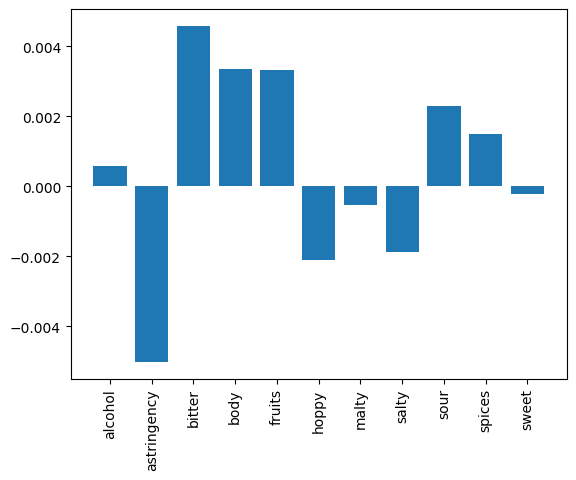

In [5]:
plt.bar(["alcohol", "astringency", "bitter", "body", "fruits", "hoppy", "malty", "salty", "sour", "spices", "sweet"], reg.coef_[0])
plt.xticks(rotation=90)
plt.show()

In [6]:
pd.DataFrame(zip(["alcohol", "astringency", "bitter", "body", "fruits", "hoppy", "malty", "salty", "sour", "spices", "sweet"],reg.coef_[0])).to_csv(os.path.join("..", "..", "data", "website_preparation", "regression_coeffs.csv"), header=False, index=False)

# Gravity Balls

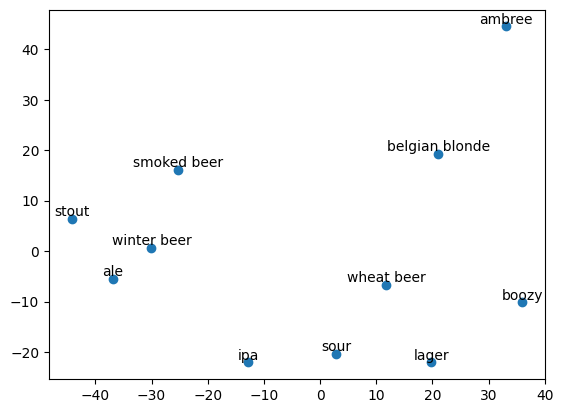

In [19]:
aromes = ["alcohol", "astringency", "bitter", "body", "fruits", "hoppy", "malty", "salty", "sour", "spices", "sweet"]
DATA = BEERS[["meta_style", *aromes]]
DATA = DATA[DATA["meta_style"] != "Other"]
DATA = DATA[DATA["meta_style"] != "alcohol-free"]
DATA[aromes] = DATA[aromes].apply(lambda x: (x - x.mean()) / x.std())
DATA = DATA.groupby("meta_style").mean()
DATA["posx"] = 100*np.random.random(size=[DATA.shape[0],1])-50
DATA["posy"] = 100*np.random.random(size=[DATA.shape[0],1])-50
plt.scatter(DATA["posx"], DATA["posy"])
for (xi, yi, ni) in zip(DATA["posx"], DATA["posy"], DATA.index):
    plt.text(xi, yi, ni, va='bottom', ha='center')
plt.show()

In [20]:
def dist(x,y,method="cos"):
    if method == "cos":
        return x.dot(y)/(np.linalg.norm(x)*np.linalg.norm(y))
    if method == "euclid":
        return np.linalg.norm(x-y)

distance_matrix = np.zeros([DATA.shape[0],DATA.shape[0]])
for i in range(DATA.shape[0]):
    for j in range(i,DATA.shape[0]):
        d = dist(
            np.array(DATA[["alcohol", "astringency", "bitter", "body", "fruits", "hoppy", "malty", "salty", "sour", "spices", "sweet"]].iloc[i,:]),
            np.array(DATA[["alcohol", "astringency", "bitter", "body", "fruits", "hoppy", "malty", "salty", "sour", "spices", "sweet"]].iloc[j,:]),
            method = "euclid"
        )
        distance_matrix[i,j] = d
        distance_matrix[j,i] = d

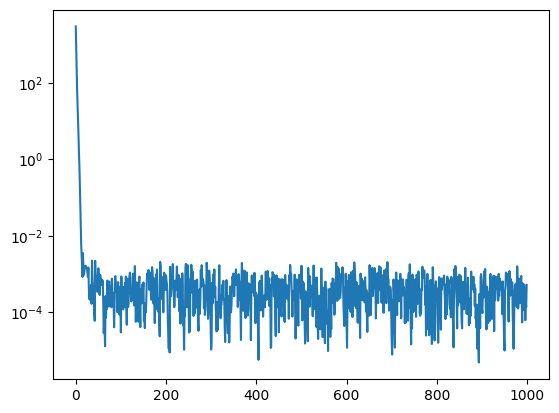

In [21]:
attract = 10
repuls = 1
stepsize = 0.01
step = []
for _ in range(1000):
    temp = 0
    for i in range(DATA.shape[0]):
        dx = np.zeros([2])
        for j in range(DATA.shape[0]):
            if i != j and np.random.rand() > 0.02:
                dist = np.array([DATA["posx"].iloc[j] - DATA["posx"].iloc[i], DATA["posy"].iloc[j] - DATA["posy"].iloc[i]])
                dx -= repuls / np.linalg.norm(dist) * dist / np.linalg.norm(dist)
                dx += attract / distance_matrix[i,j] * dist
        DATA["posx"].iloc[i] += stepsize*dx[0]
        DATA["posy"].iloc[i] += stepsize*dx[1]
        temp += stepsize*stepsize*dx.dot(dx)
    step.append(temp)
    if temp < 1e-8:
        break
plt.plot(step)
plt.yscale('log')
plt.show()

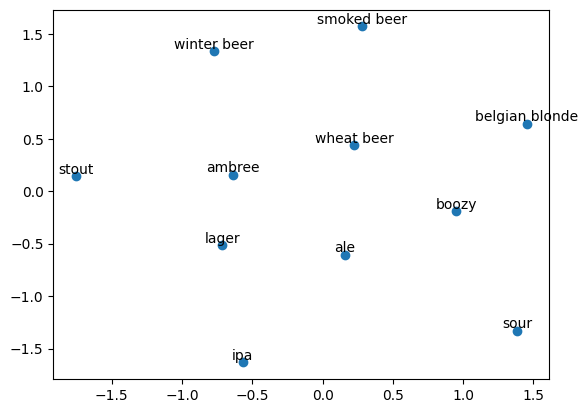

In [24]:
DATA[["posx", "posy"]] = DATA[["posx", "posy"]].apply(lambda x: (x - x.mean()) / x.std())
plt.scatter(DATA["posx"], DATA["posy"])
for (xi, yi, ni) in zip(DATA["posx"], DATA["posy"], DATA.index):
    plt.text(xi, yi, ni, va='bottom', ha='center')
plt.show()

In [26]:
pd.DataFrame(DATA[["posx","posy"]]).to_csv(os.path.join("..", "..", "data", "website_preparation", "balls_pos.csv"), header=False, index=True)